This compressed notebook focuses solely on demonstrating the modeling approach.



## Load libraries

In [1]:
import pandas as pd # load and manipulate data
import numpy as np # calculation
import matplotlib.pyplot as plt # visualize data
from sklearn.preprocessing import OneHotEncoder # To one-hot encode variables
import category_encoders as ce # To target encode high cardinality variables
from datetime import datetime
# to build the model
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV # to fine tune hyperparameters
import shap # to explore feature importance

c:\Users\ngtran\LearningPython\time_series\time_series\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [9]:
# Read the CSV file, ignoring the first column
demand = pd.read_csv('processed_data.csv', encoding='latin1', usecols=lambda column: column != 'Unnamed: 0')

# Ensure the 'date' column is in datetime format
demand['date'] = pd.to_datetime(demand['date'])

# Sort the data by date, then product_id
demand = demand.sort_values(by=['date'])

In [10]:
# Review

print(demand.head().to_string())

            date   product_id                                                      product_name  traffic  impressions  payment  revenue  product_ad_spend  shop_ad_spend  product_page_bounce_count  traffic_from_search  run_product_ad  run_shop_ad  conversion_rate  wm_yr_wk  wday  month  d  doubleday  near_dday  end_of_month  weekend  other_commercial_sale  day_offs  day_of_year  week_of_month  est_avg_price  avg_price  promotion_on  promotion_price  discount_rate  comment_received  product_rating  avg_category_comment  avg_category_rate  high_rating  high_comment  high_discount  wday_sin  wday_cos  month_sin  month_cos  wom_sin  wom_cos  day_of_year_sin  day_of_year_cos  payment_lag_3  payment_lag_28  revenue_lag_3  revenue_lag_28  product_ad_spend_lag_3  product_ad_spend_lag_28  shop_ad_spend_lag_3  shop_ad_spend_lag_28  traffic_rolling_7d_mean  impressions_rolling_7d_mean  payment_rolling_7d_mean  revenue_rolling_7d_mean  product_ad_spend_rolling_7d_mean  shop_ad_spend_rolling_7d_mean

## Modeling

### Define features and target

In [11]:
# Review all variables
demand.columns.tolist()

['date',
 'product_id',
 'product_name',
 'traffic',
 'impressions',
 'payment',
 'revenue',
 'product_ad_spend',
 'shop_ad_spend',
 'product_page_bounce_count',
 'traffic_from_search',
 'run_product_ad',
 'run_shop_ad',
 'conversion_rate',
 'wm_yr_wk',
 'wday',
 'month',
 'd',
 'doubleday',
 'near_dday',
 'end_of_month',
 'weekend',
 'other_commercial_sale',
 'day_offs',
 'day_of_year',
 'week_of_month',
 'est_avg_price',
 'avg_price',
 'promotion_on',
 'promotion_price',
 'discount_rate',
 'comment_received',
 'product_rating',
 'avg_category_comment',
 'avg_category_rate',
 'high_rating',
 'high_comment',
 'high_discount',
 'wday_sin',
 'wday_cos',
 'month_sin',
 'month_cos',
 'wom_sin',
 'wom_cos',
 'day_of_year_sin',
 'day_of_year_cos',
 'payment_lag_3',
 'payment_lag_28',
 'revenue_lag_3',
 'revenue_lag_28',
 'product_ad_spend_lag_3',
 'product_ad_spend_lag_28',
 'shop_ad_spend_lag_3',
 'shop_ad_spend_lag_28',
 'traffic_rolling_7d_mean',
 'impressions_rolling_7d_mean',
 'payment_

#### Exclude some variables out of features used for training:
* Prevent data leakage: Ensure that information unavailable at prediction time is not included in the training process.
* Avoid duplication: Eliminate redundant features that may skew the model's learning.
* Align with learning objectives: Select features based on the specific goals of the model.

In [12]:
exclude_cols = ['date', 'product_id', 'product_name', 'conversion_rate', 'payment', 'revenue_rolling_28d_mean', 'revenue_rolling_7d_mean', 'revenue_lag_28', 'revenue_lag_3', 'd', 'revenue', 'est_avg_price']  # Adjust as needed
features = [col for col in demand.columns if col not in exclude_cols]
target = 'payment'

## Cross-validation
Train on historical data up to some month, validate on the next month.
* To fine-tune model hyperparameters
* To see stability in RMSE score through each folds to see if the model is stable across months, meaning the model generalizes well.

In [13]:
## Define the folds for time-series CV
# Helper function for creating CV folds while reserving time order
def split_by_month(df, train_end_month, val_month, features, target):
    train_end = pd.to_datetime(train_end_month + '-01') + pd.offsets.MonthEnd(1)
    val_start = pd.to_datetime(val_month + '-01')
    val_end = val_start + pd.offsets.MonthEnd(1)

    train_df = df[df['date'] <= train_end]
    val_df = df[(df['date'] >= val_start) & (df['date'] <= val_end)]

    X_train = train_df[features]
    y_train = train_df[target]
    X_val = val_df[features]
    y_val = val_df[target]

    # Create sample weights for training data to boost doubleday
    sample_weights = np.where(X_train['doubleday'] == 1, 10.0, 1.0)

    return X_train, y_train, X_val, y_val, sample_weights

# ---- TIME-BASED CROSS-VALIDATION ----

train_end_month_list = ['2024-08', '2024-09', '2024-10', '2024-11', '2024-12']
val_month_list       = ['2024-09', '2024-10', '2024-11', '2024-12', '2025-01']

## Hyperparameter tuning

In [14]:
# Define the hyperparameters to fine-tune
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.8, 1.0]
}

In [15]:
best_score = float('inf')
best_params = None

# For each combination in our parameter grid:
for lr in param_grid['learning_rate']:
    for md in param_grid['max_depth']:
        for subs in param_grid['subsample']:

            # Accumulate RMSE scores across all (train_end, val_month) folds
            cv_rmse_scores = []

            # Time-based CV loop:
            for train_end, val_month in zip(train_end_month_list, val_month_list):
                # 1) Split data
                X_train, y_train, X_val, y_val, sample_weights = split_by_month(
                    demand, train_end, val_month, features, target
                )

                # 2) Keep only numeric/categorical/bool columns
                X_train = X_train.select_dtypes(include=[np.number, 'category', 'bool'])
                X_val   = X_val.select_dtypes(include=[np.number, 'category', 'bool'])

                # 3) Convert to DMatrix
                dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
                dval   = xgb.DMatrix(X_val, label=y_val)

                # 4) Build parameter dict
                params = {
                    'booster': 'gbtree',
                    'objective': 'reg:squarederror',
                    'learning_rate': lr,
                    'max_depth': md,
                    'subsample': subs
                }

                # 5) Train model
                model = xgb.train(
                    params=params,
                    dtrain=dtrain,
                    num_boost_round=1000,
                    evals=[(dval, 'eval')],
                    early_stopping_rounds=50,
                    verbose_eval=False
                )

                # 6) Compute validation RMSE
                val_preds = model.predict(dval)
                val_rmse = np.sqrt(np.mean((y_val - val_preds) ** 2))
                cv_rmse_scores.append(val_rmse)

            # Average RMSE for this param set
            avg_rmse = np.mean(cv_rmse_scores)

            # Check if it beats our best so far
            if avg_rmse < best_score:
                best_score = avg_rmse
                best_params = {
                    'learning_rate': lr,
                    'max_depth': md,
                    'subsample': subs
                }
                print(f"New best score: {best_score:.3f} with {best_params}")

# Finally, report the best overall
print("\n=== Best Hyperparameters ===")
print(best_params)
print(f"Best average RMSE: {best_score:.3f}")

New best score: 0.331 with {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.5}
New best score: 0.329 with {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.8}

=== Best Hyperparameters ===
{'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.8}
Best average RMSE: 0.329


Since these hyperparameters:

``` 
params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'learning_rate': 0.01,
        'max_depth': 3,
        'subsample': 0.8
    }
```

yield the smallest `average RMSE`: 0.329 (at the time). I will use this set-up to build the final model with all the data.

## Final model

In [16]:
# Define train and validation set

# 1) Split the data
train_end_date = pd.to_datetime('2024-12-31') 
test_start_date = pd.to_datetime('2025-01-01') 
test_end_date = pd.to_datetime('2025-01-31')  

train_df = demand[demand['date'] <= train_end_date]
test_df  = demand[(demand['date'] >= test_start_date) & (demand['date'] <= test_end_date)]

# 2) Create training/test sets
X_train = train_df[features]
y_train = train_df[target]
X_test  = test_df[features]
y_test  = test_df[target]

# 3) Create sample weights for training
sample_weights = np.where(X_train['doubleday'] == 1, 10.0, 1.0)

# 4) Convert to numeric/categorical/bool as needed 
X_train = X_train.select_dtypes(include=[np.number, 'category', 'bool'])
X_test  = X_test.select_dtypes(include=[np.number, 'category', 'bool'])

# 5) Create DMatrices
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
dtest  = xgb.DMatrix(X_test, label=y_test)

# 6) Use the same hyperparameters from cross-validation training
final_params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'learning_rate': 0.01,
    'max_depth': 3,
    'subsample': 0.8
}

# 7) Train final model
final_model = xgb.train(
    params=final_params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtest, 'eval')], 
    early_stopping_rounds=50,
    verbose_eval=True
)

# 8) Generate predictions on December 2024
test_preds = final_model.predict(dtest)

# 9) Compute RMSE
final_rmse = np.sqrt(np.mean((y_test - test_preds) ** 2))
print(f"Final Test RMSE from {test_start_date} to {test_end_date} is: {final_rmse:.3f}")

[0]	eval-rmse:0.46692
[1]	eval-rmse:0.46451
[2]	eval-rmse:0.46130
[3]	eval-rmse:0.45855
[4]	eval-rmse:0.45593
[5]	eval-rmse:0.45369
[6]	eval-rmse:0.45057
[7]	eval-rmse:0.44781
[8]	eval-rmse:0.44481
[9]	eval-rmse:0.44189
[10]	eval-rmse:0.43927
[11]	eval-rmse:0.43688
[12]	eval-rmse:0.43436
[13]	eval-rmse:0.43192
[14]	eval-rmse:0.42951
[15]	eval-rmse:0.42775
[16]	eval-rmse:0.42551
[17]	eval-rmse:0.42348
[18]	eval-rmse:0.42126
[19]	eval-rmse:0.41877
[20]	eval-rmse:0.41655
[21]	eval-rmse:0.41415
[22]	eval-rmse:0.41283
[23]	eval-rmse:0.41113
[24]	eval-rmse:0.40939
[25]	eval-rmse:0.40740
[26]	eval-rmse:0.40522
[27]	eval-rmse:0.40291
[28]	eval-rmse:0.40091
[29]	eval-rmse:0.39870
[30]	eval-rmse:0.39718
[31]	eval-rmse:0.39499
[32]	eval-rmse:0.39285
[33]	eval-rmse:0.39126
[34]	eval-rmse:0.38971
[35]	eval-rmse:0.38818
[36]	eval-rmse:0.38649
[37]	eval-rmse:0.38520
[38]	eval-rmse:0.38318
[39]	eval-rmse:0.38137
[40]	eval-rmse:0.38038
[41]	eval-rmse:0.37929
[42]	eval-rmse:0.37812
[43]	eval-rmse:0.3765

### Save the model to a file

In [17]:
final_model.save_model('ecom_pred_xgboost_model.json')

# Later, you can load it back like this:
# loaded_model = xgb.Booster()
# loaded_model.load_model('xgboost_model.json')

## Plot Prediction vs. Actual

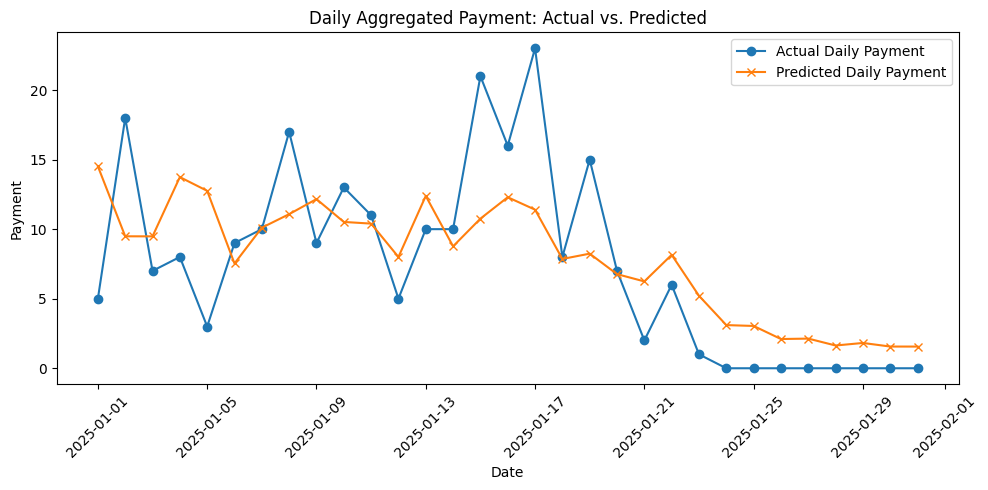

In [18]:
val_df = demand[(demand['date'] >= '2025-01-01') & (demand['date'] <= '2025-01-31')].copy()

# # Very important!: Ensure val_df is sorted by the same order as the original's dataframe order for a proper line plot
# val_df.sort_values(by=['product_id', 'date'], inplace=True)

val_df['predicted_payment'] = test_preds

# 1) Aggregate payments by date
daily_agg = (
    val_df
    .groupby('date', as_index=False)
    .agg({'payment': 'sum', 'predicted_payment': 'sum'})
    .rename(columns={
        'payment': 'actual_daily_payment',
        'predicted_payment': 'predicted_daily_payment'
    })
)

# 2) Ensure chronological order
daily_agg.sort_values('date', inplace=True)

# 3) Plot both series on the same line chart
plt.figure(figsize=(10, 5))
plt.plot(daily_agg['date'], daily_agg['actual_daily_payment'], marker='o', label='Actual Daily Payment')
plt.plot(daily_agg['date'], daily_agg['predicted_daily_payment'], marker='x', label='Predicted Daily Payment')
plt.xlabel('Date')
plt.ylabel('Payment')
plt.title('Daily Aggregated Payment: Actual vs. Predicted')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Note: Entering the new year, prediction in January 2025 is not as in tune with actual target as before (previous months), suggesting better feature engineering is needed to learn user behavior in January and the new year.

## Feature Importance

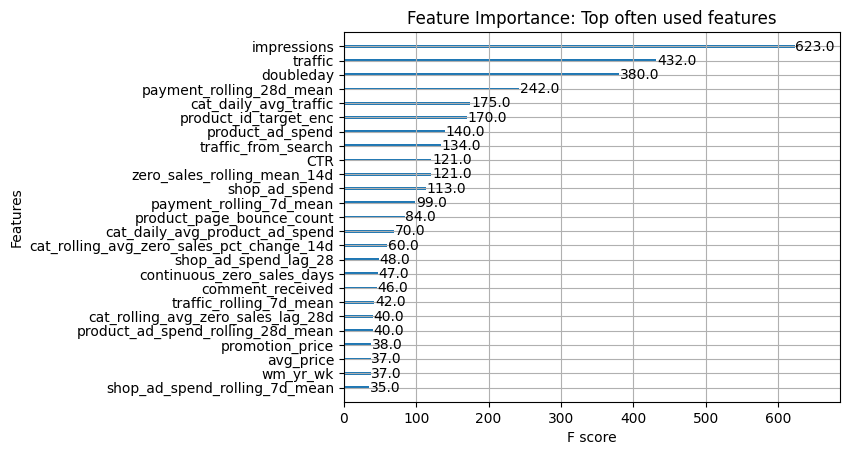

In [21]:
xgb.plot_importance(final_model, max_num_features=25)
plt.title("Feature Importance: Top often used features")
plt.show()

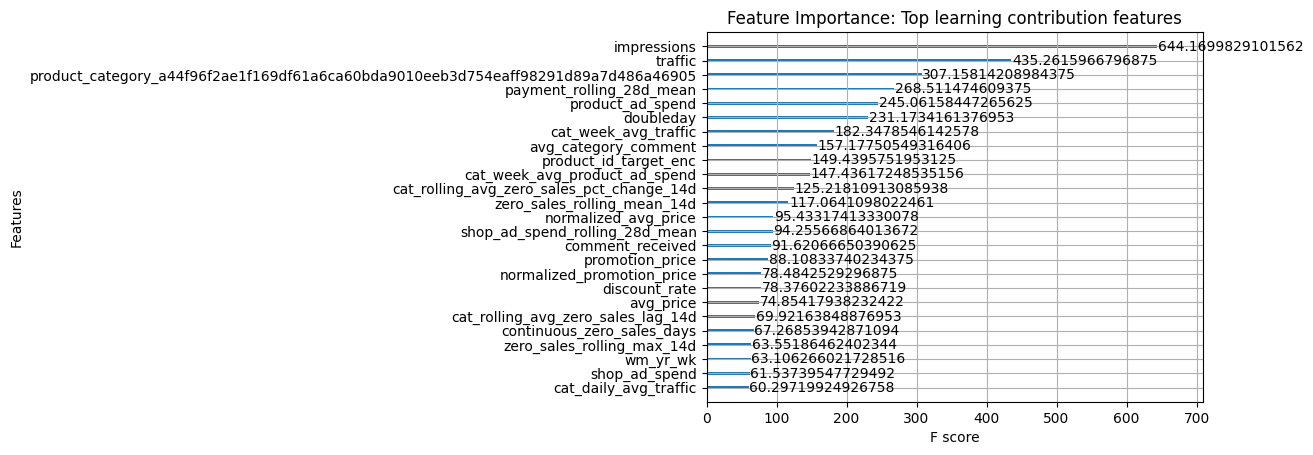

In [22]:
xgb.plot_importance(final_model, importance_type='gain', max_num_features=25)
plt.title("Feature Importance: Top learning contribution features")
plt.show()

### SHAP summary plot

c:\Users\ngtran\LearningPython\time_series\time_series\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


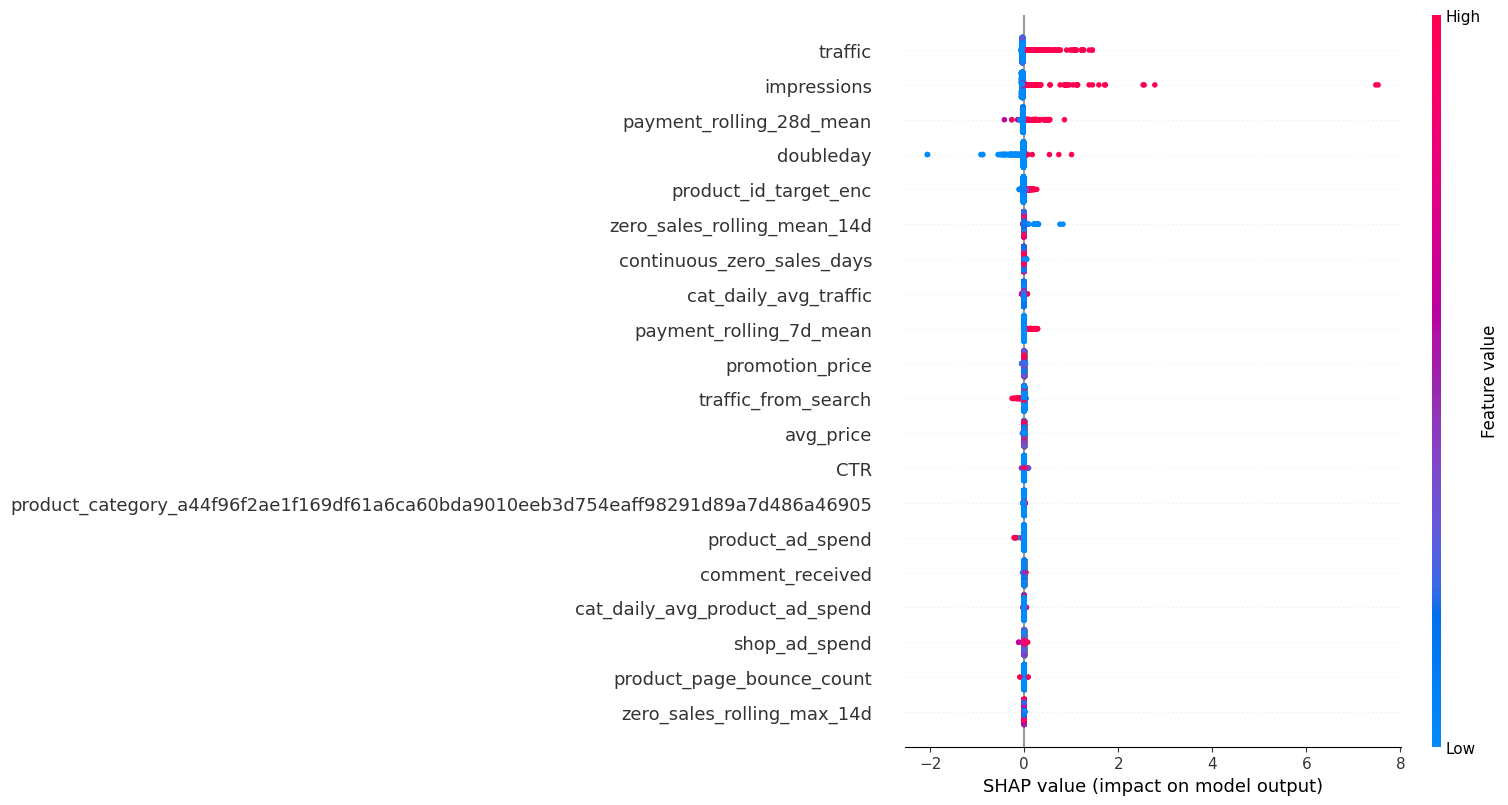

In [28]:
explainer = shap.Explainer(final_model)
shap_values = explainer(X_test)
shap_interaction_values = explainer.shap_interaction_values(X_test)
shap.summary_plot(shap_values, X_test)

### Key Observations from the SHAP Summary Plot and Feature importance charts
#### Top Influential Features:

* `traffic`: The most important feature, with high values (red) strongly pushing predictions higher (positive SHAP values). More traffic correlates with increased output.

* `product_id_target_enc`: Some products are inherently stronger performers.

* `impressions`: Higher impressions improve predictions, though not as decisively as traffic.

#### Negative Impact Features:

* `zero_sales_rolling_mean_14d`: Past zero-sales periods hurt predictions, indicating historical stockouts or poor demand.

* `traffic_from_search`: Decrease in this feature hurt predictions.

#### Mixed or Contextual Impact: 
Features such as `product_ad_spend`, `doubleday`, `avg_price`, etc. spread across both side of the 0 threshold, indicating that we need to explore their dependencies with other features or contextual factors.

For example: `doubleday` only push sales for certain products with consecutive good sales performance in the past 28 days.

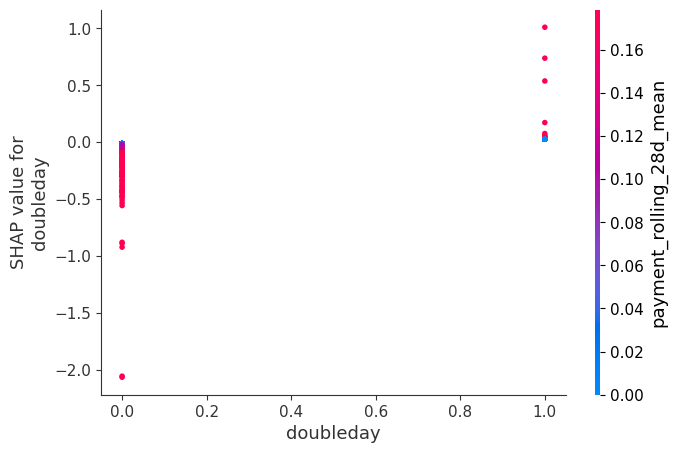

In [34]:
# Which feature when matched with `doubleday` impact outcome the most
shap.dependence_plot("doubleday", shap_values.values, X_test, interaction_index="auto")

### Actionable Insights
#### Prioritize Traffic Growth:

* Invest in SEO, marketing campaigns, or partnerships to drive quality `traffic`, as it’s the strongest predictor of positive outcomes.

* Address Zero-Sales Periods: Investigate root causes of historical zero-sales days (e.g., stockouts, pricing issues, demand research, etc.).

* Optimize Ad Spend: Further investigate this feature's interactions with others when driving positive results (for example: run ads to boost traffic for proven top performing products on `doubleday`)

* Leverage Product-Specific Trends: Use `product_id_target_enc` insights to promote top-performing products or improve underperformers through pricing/bundling.

* Monitor Category Health: Category-level metrics (`cat_rolling_avg_zero_sales_14d`) impact predictions. Collaborate with category managers to address broader trends (e.g., seasonal demand shifts).

### Further feature importance exploration: TBU